# FX

This notebook illustrates some basic aspects of FX markets, for instance, the definition of currency returns and the idea of UIP.

## Load Packages and Extra Functions

In [1]:
using Printf

include("jlFiles/printmat.jl");

In [2]:
using Plots

#pyplot(size=(600,400))
gr(size=(480,320))
default(fmt = :png)

# Exchange Rate Quotations: Cross-Rates

In [3]:
CHF_USD = 0.9500                       #how many CHF to pay for 1 USD
USD_AUD = 0.8000

CHF_AUD = CHF_USD*USD_AUD

printblue("A cross rate:\n")
printmat([CHF_USD,USD_AUD,CHF_AUD],rowNames=["CHF/USD","USD/AUD","=> CHF/AUD ≈"],prec=4)

A cross rate:

CHF/USD         0.9500
USD/AUD         0.8000
=> CHF/AUD ≈    0.7600



# Currency Returns

The strategy is: 
- in $t=0$: buy foreign currency (at the price $S_0$) and lend on foreign money market (at the safe rate $R_f^*$).
- in $t=1$: sell the foreign currency (at the price $S_1$)

Since the strategy is financed by borrowing on the domestic money market (at the rate $R_f$), the excess return is

$
R^e = (1+R_f^*)S_1/S_0 - (1 + R_f)
$

Notice that $R_f$ and $R_f^*$  are the safe rates over the investment period (for instance, one-month period). Conversion from annualized interest rates to these monthly rates is discussed under UIP (below).

In [4]:
S₀ = 1.2            #current spot FX rate, t=0
S₁ = 1.25           #spot FX rate in t=1
Rfstar = 0.06       #safe rate (foreign) between period 0 and 1
Rf     = 0.04       #safe domestic rate

Re = (1+Rfstar)*S₁/S₀ - (1 + Rf)

printblue("A simple example of how to calculate the excess return from investing in a foreign currency:\n")
xx = [S₀,Rf,Rfstar,S₁,Re]
printmat(xx,rowNames=["S₀";"Rf";"Rfstar";"S₁";"Currency excess return"])

A simple example of how to calculate the excess return from investing in a foreign currency:

S₀                         1.200
Rf                         0.040
Rfstar                     0.060
S₁                         1.250
Currency excess return     0.064



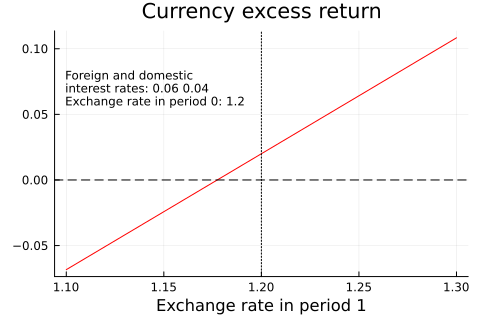

In [5]:
S₁_range = 1.1:0.01:1.3           #range of different possible exchange rates in t=1

Re = (1+Rfstar)*S₁_range/S₀ .- (1 + Rf)  #corresponding returns

txt = "Foreign and domestic \ninterest rates: $Rfstar $Rf \nExchange rate in period 0: $S₀"

p1 = plot( S₁_range,Re,
           legend = nothing,
           linecolor = :red,
           title = "Currency excess return",
           xlabel = "Exchange rate in period 1",
           annotation = (1.1,0.07,text(txt,8,:left)) )
vline!([S₀],linecolor=:black,line=(:dot,1))
hline!([0],linecolor=:black,line=(:dash,1))
display(p1)

# Uncovered Interest Rate Parity (UIP)


UIP assumes that the expected future exchange rate ($\text{E}_0S_m$) is related to the current (as of $t=0$) exchange rate and interest rates in such a way that the expected excess return of a foreign investment is zero (set $R^e=0$ in the previous expression).

Also, interest rates are typically annualized (denoted $Y$ and $Y^*$ below). This means that the safe (gross) rate over an investment period of $m$ years (eg. $m=1/12$ for a month) is $(1+Y)^m$.

In [6]:
S₀    = 1.2                       #current spot FX rate
Y     = 0.04                      #annualized interest rates
Ystar = 0.06
m     = 1/2                       #investment period
ESₘ   = S₀ * (1+Y)^m/(1+Ystar)^m  #implies E(excess return) = 0

printblue("Expected future exchange rate $m years ahead according to UIP:\n")
xx = [S₀,Y,Ystar,m,ESₘ]
printmat(xx,rowNames=["S₀";"Y";"Ystar";"m";"UIP 'expectation' of Sₘ"])

Expected future exchange rate 0.5 years ahead according to UIP:

S₀                          1.200
Y                           0.040
Ystar                       0.060
m                           0.500
UIP 'expectation' of Sₘ     1.189

